In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
data_path = '../../data/postprocessed/INPUTSSA/'

mapping_table = {
    'gpuburn5min0': 'Single alternative',
    'gpuburn5min1': 'Couple alternative',
    'gpuburn5min2': 'Triple alternative',
    'gpuburn5min3': 'Quadruple alternative',
    'gpuburn5min4': 'Quintuple alternative',
    'gpuburn5min5': 'Sixtuple alternative',
    'gpuburn5minRandom': 'Original GPU-burn'
}

data_sheet = pd.DataFrame()
for csv_name in [file for file in os.listdir(data_path) if (('NN50Perc' in file or '5min' in file) and not 'telemetry' in file)]:
    csv_full_path = os.path.join(data_path, csv_name)
    print(csv_full_path)
    df = pd.read_csv(csv_full_path)
    df['Range'] = int(csv_name.split('_')[1].split('.')[0])
    df['App_name'] = mapping_table[csv_name.split('_')[0]]
    df['progress'] = (df['session_id'] - df['session_id'].min()) / (df['session_id'].max() - df['session_id'].min()) * 100
    # print(df[df.isna()])
    data_sheet=pd.concat([data_sheet, df], ignore_index=True)

location_mapping={
    'sm': 'Streaming Multiprocessor',
    'dram': 'Dynamic RAM',
    'l1tex': 'L1 Cache',
    'lts': 'L2 Cache',
    'smsp': 'Streaming Multiprocessor SubPartition'
}
data_sheet['HR_location'] = data_sheet['location'].map(location_mapping)

metric_event_mapping= {

    # Workload
    ## Compute
    'request_cycles_active': 'Number of cycles where the IDC processed requests from SM',
    'instruction_throughput': 'Instruction throughput',
    'inst_executed': 'Executed instructions',
    'inst_issued': 'Issued instructions',
    'sass_thread_inst_executed_op_fp64_pred_on': 'Instructions FP64',
    'sass_thread_inst_executed_op_integer_pred_on': 'Instructions Integers',

    ## Memory
    ### DRAM
    'bytes_read': 'Read Bytes',
    'bytes_write': 'Written bytes',

    ### L1 Cache
    't_sectors_pipe_lsu_mem_global_op_ld_lookup_hit': 'Global Memory Load Sectors – Cache Hit (per Thread Set via LSU)',
    't_sectors_pipe_lsu_mem_global_op_st_lookup_hit': 'Global Memory Store Sectors – Cache Hit (per Thread Set via LSU)',
    't_sectors_pipe_lsu_mem_global_op_red_lookup_hit': 'Global Memory Reduction – Cache Hit (per Thread Set via LSU)',
    't_sectors_pipe_lsu_mem_global_op_atom_lookup_hit': 'Global Memory Atomic – Cache Hit (per Thread Set via LSU)',
    't_sectors_pipe_lsu_mem_global_op_ld': ' Global Memory Load Sectors Served by L1 Cache (via LSU)',
    't_sectors_pipe_lsu_mem_global_op_st': ' Global Memory Store Sectors Served by L1 Cache (via LSU)',
    't_sectors_pipe_lsu_mem_global_op_red': 'Global Memory Reduction Sectors Served by L1 Cache (via LSU)',
    't_sectors_pipe_lsu_mem_global_op_atom': 'Global Memory Atomic Sectors Served by L1 Cache (via LSU)',
    
    ### L2 Cache
    't_sector_op_read_hit_rate': 'L2 hit rate by read instruction',
    't_sector_op_write_hit_rate': 'L2 hit rate by write instruction',

    # Stall
    ## Memory
    'warp_issue_stalled_imc_miss_per_warp_active': 'Warp Issue Stalls Due to IMC (Immediate Constant Cache) Misses per Active Warp ',
    'warp_issue_stalled_long_scoreboard_per_warp_active': 'Warp Issue Stalls Due to Long Scoreboard (Long Wait for Resource) per Active Warp',

    ## Controller
    'warp_issue_stalled_short_scoreboard_per_warp_active': 'Warp Issue Stalls Due to Short Scoreboard (Resource Wait) per Active Warp',
    'warp_issue_stalled_wait_per_warp_active': 'Warp Issue Stalls Due to Wait (Resource/Data Not Ready) per Active Warp',
    'warp_issue_stalled_not_selected_per_warp_active': 'Warp Issue Stalls Due to Not Being Selected per Active Warp',
    'warp_issue_stalled_sleeping_per_warp_active': 'Warp Issue Stalls Due to Sleeping per Active Warp',
    'warp_issue_stalled_membar_per_warp_active': 'Warp Issue Stalls Due to Membar per Active Warp',
    'warp_issue_stalled_barrier_per_warp_active': 'Warp Issue Stalls Due to Barrier per Active Warp',
    'warp_issue_stalled_dispatch_stall_per_warp_active': 'Warp Issue Stalls Due to Dispatch Stall per Active Warp',

    ## Throttle
    'warp_issue_stalled_drain_per_warp_active': 'Warp Issue Stalls Due to Drain (Memory/Resource Write Completion) per Active Warp',
    'warp_issue_stalled_lg_throttle_per_warp_active': 'Warp Issue Stalls Due to Large Unit Throttling (Resource Limitation) per Active Warp',
    'warp_issue_stalled_math_pipe_throttle_per_warp_active': 'Warp Issue Stalls Due to Math Pipe Throttling per Active Warp',
    'warp_issue_stalled_mio_throttle_per_warp_active': 'Warp Issue Stalls Due to MIO Throttling per Active Warp',
    'warp_issue_stalled_tex_throttle_per_warp_active': 'Warp Issue Stalls Due to Texture Throttling per Active Warp',

    ## Others
    'warp_issue_stalled_misc_per_warp_active': 'Warp Issue Stalls Due to Miscellaneous Issues per Active Warp',

}
data_sheet['metric_name'].unique()

data_sheet['HR_metric_name'] = data_sheet['metric_name'].map(metric_event_mapping)

df_l2 = data_sheet[data_sheet['HR_location']=='L2 Cache']
df_sm = data_sheet[data_sheet['HR_location']=='Streaming Multiprocessor']
df_smsp = data_sheet[data_sheet['HR_location']=='Streaming Multiprocessor SubPartition']
df_l1 = data_sheet[data_sheet['HR_location']=='L1 Cache']
df_dram = data_sheet[data_sheet['HR_location']=='Dynamic RAM']

dfs = {
    'L2 Cache': df_l2, 
    'Streaming Multiprocessor': df_sm, 
    'Streaming Multiprocessor SubPartition': df_smsp, 
    'L1 Cache': df_l1, 
    'Dynamic RAM': df_dram
    }

df_pivot_l2 = df_l2.pivot_table(
    index=["progress", "HR_location", "range_name", "Range", "App_name", 'rollup_operation', 'Post'],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_sm = df_sm.pivot_table(
    index=["progress", "HR_location", "range_name", "Range", "App_name", 'rollup_operation', 'Post'],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_smsp = df_smsp.pivot_table(
    index=["progress", "HR_location", "range_name", "Range", "App_name", 'rollup_operation', 'Post'],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_smsp['Memory Stall']=(df_pivot_smsp['Warp Issue Stalls Due to IMC (Immediate Constant Cache) Misses per Active Warp '] +\
              df_pivot_smsp['Warp Issue Stalls Due to Long Scoreboard (Long Wait for Resource) per Active Warp']) /2

df_pivot_smsp['Controller Stall']=(df_pivot_smsp['Warp Issue Stalls Due to Not Being Selected per Active Warp'] +\
                df_pivot_smsp['Warp Issue Stalls Due to Short Scoreboard (Resource Wait) per Active Warp'] +\
                df_pivot_smsp['Warp Issue Stalls Due to Wait (Resource/Data Not Ready) per Active Warp'] +\
                df_pivot_smsp['Warp Issue Stalls Due to Sleeping per Active Warp'] +\
                df_pivot_smsp['Warp Issue Stalls Due to Membar per Active Warp'] +\
                df_pivot_smsp['Warp Issue Stalls Due to Barrier per Active Warp'] ) /7

df_pivot_smsp['Throttle Stall']=(df_pivot_smsp['Warp Issue Stalls Due to Drain (Memory/Resource Write Completion) per Active Warp'] +\
                                df_pivot_smsp['Warp Issue Stalls Due to Large Unit Throttling (Resource Limitation) per Active Warp'] +\
                                df_pivot_smsp['Warp Issue Stalls Due to Math Pipe Throttling per Active Warp'] +\
                                df_pivot_smsp['Warp Issue Stalls Due to MIO Throttling per Active Warp'] +\
                                df_pivot_smsp['Warp Issue Stalls Due to Texture Throttling per Active Warp']) /5

df_pivot_l1 = df_l1.pivot_table(
    index=["progress", "HR_location", "range_name", "Range", "App_name", 'rollup_operation', 'Post'],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_l1['Global hit rate'] = (df_pivot_l1['Global Memory Atomic – Cache Hit (per Thread Set via LSU)']+ \
                                df_pivot_l1['Global Memory Load Sectors – Cache Hit (per Thread Set via LSU)']+\
                                df_pivot_l1['Global Memory Reduction – Cache Hit (per Thread Set via LSU)']+\
                                df_pivot_l1['Global Memory Store Sectors – Cache Hit (per Thread Set via LSU)']) / \
                                (df_pivot_l1[' Global Memory Load Sectors Served by L1 Cache (via LSU)']+ \
                                df_pivot_l1[' Global Memory Store Sectors Served by L1 Cache (via LSU)']+\
                                df_pivot_l1['Global Memory Atomic Sectors Served by L1 Cache (via LSU)']+\
                                df_pivot_l1['Global Memory Reduction Sectors Served by L1 Cache (via LSU)'])

df_pivot_dram = df_dram.pivot_table(
    index=["progress", "HR_location", "range_name", "Range", "App_name", 'rollup_operation', 'Post'],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

pivot_dfs = {
    'L2 Cache': df_pivot_l2, 
    'Streaming Multiprocessor': df_pivot_sm, 
    'Streaming Multiprocessor SubPartition': df_pivot_smsp, 
    'L1 Cache': df_pivot_l1, 
    'Dynamic RAM': df_pivot_dram
    }

../../data/postprocessed/INPUTSSA/gpuburn5min1_1.csv
../../data/postprocessed/INPUTSSA/gpuburn5min5_1.csv
../../data/postprocessed/INPUTSSA/gpuburn5min0_1.csv
../../data/postprocessed/INPUTSSA/gpuburn5min2_1.csv
../../data/postprocessed/INPUTSSA/gpuburn5min3_1.csv
../../data/postprocessed/INPUTSSA/gpuburn5min4_1.csv


## Cumulative analysis

In [9]:
a = pivot_dfs['L1 Cache'].groupby(by=["App_name"])[['Global hit rate']]\
    .mean()\
        .reset_index()

b = pivot_dfs['L2 Cache'].groupby(by=["App_name"])[[ 'L2 hit rate by read instruction','L2 hit rate by write instruction']]\
    .mean()\
        .reset_index()

c = pivot_dfs['Streaming Multiprocessor'].groupby(by=["App_name"])[[ 'Executed instructions','Instruction throughput', 'Issued instructions']]\
    .mean()\
        .reset_index()

d = pivot_dfs['Dynamic RAM'].groupby(by=["App_name"])[[ 'Read Bytes', 'Written bytes']]\
    .mean()\
        .reset_index()

e = pivot_dfs['Streaming Multiprocessor SubPartition'].groupby(by=["App_name"])[['Memory Stall', 'Controller Stall', 'Throttle Stall']]\
    .mean()\
        .reset_index()

merge_1 = pd.merge(a, b[['App_name', 'L2 hit rate by read instruction','L2 hit rate by write instruction']], on='App_name')
merge_2 = pd.merge(merge_1, c[['App_name', 'Executed instructions','Instruction throughput', 'Issued instructions']], on='App_name')
merge_3 = pd.merge(merge_2, d[['App_name','Read Bytes', 'Written bytes']], on='App_name')
final_merge = pd.merge(merge_3, e[['App_name', 'Memory Stall', 'Controller Stall', 'Throttle Stall']], on='App_name')
    

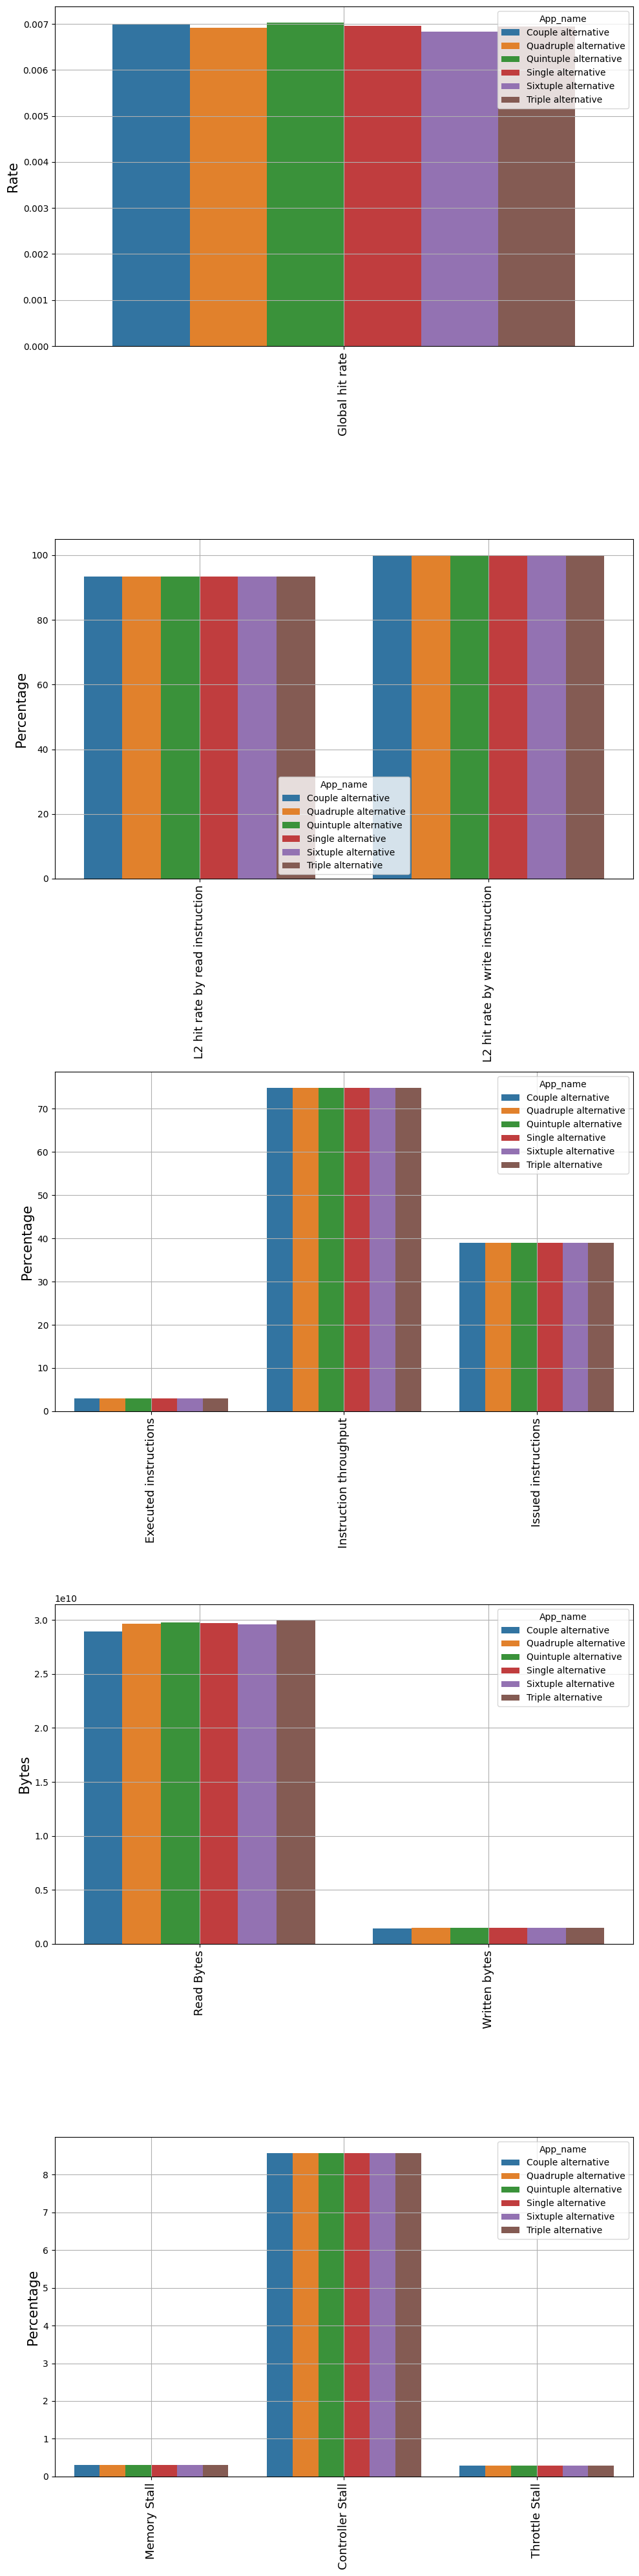

In [10]:
a_merge = pd.melt(
    a,
    id_vars='App_name',
    var_name='Metric',
    value_name='Value'
)

b_merge = pd.melt(
    b,
    id_vars='App_name',
    var_name='Metric',
    value_name='Value'
)

c_merge = pd.melt(
    c,
    id_vars='App_name',
    var_name='Metric',
    value_name='Value'
)

d_merge = pd.melt(
    d,
    id_vars='App_name',
    var_name='Metric',
    value_name='Value'
)

e_merge = pd.melt(
    e,
    id_vars='App_name',
    var_name='Metric',
    value_name='Value'
)

fig, ax = plt.subplots(5,1, figsize=(10,40))

# plt.yscale('log')
sns.barplot(data=a_merge, x='Metric', y='Value', hue='App_name', ax = ax[0])
ax[0].grid()
# ax[0].set_yscale('log')
ax[0].set_xlabel('Metric', fontsize=15)
ax[0].set_ylabel('Rate', fontsize=15)
ax[0].tick_params(axis='x', labelrotation=90, labelsize=13)
# ax[0].set_xticklabels([])
ax[0].set_xlabel('')

sns.barplot(data=b_merge, x='Metric', y='Value', hue='App_name', ax = ax[1])
ax[1].grid()
# ax[1].set_yscale('log')
ax[1].set_xlabel('Metric', fontsize=15)
ax[1].set_ylabel('Percentage', fontsize=15)
ax[1].tick_params(axis='x', labelrotation=90, labelsize=13)
# ax[1].set_xticklabels([])
ax[1].set_xlabel('')

sns.barplot(data=c_merge, x='Metric', y='Value', hue='App_name', ax = ax[2])
ax[2].grid()
# ax[2].set_yscale('log')
ax[2].set_xlabel('Metric', fontsize=15)
ax[2].set_ylabel('Percentage', fontsize=15)
ax[2].tick_params(axis='x', labelrotation=90, labelsize=13)
# ax[2].set_xticklabels([])
ax[2].set_xlabel('')

sns.barplot(data=d_merge, x='Metric', y='Value', hue='App_name', ax = ax[3])
ax[3].grid()
# ax[3].set_yscale('log')
ax[3].set_xlabel('Metric', fontsize=15)
ax[3].set_ylabel('Bytes', fontsize=15)
ax[3].tick_params(axis='x', labelrotation=90, labelsize=13)
# ax[3].set_xticklabels([])
ax[3].set_xlabel('')

sns.barplot(data=e_merge, x='Metric', y='Value', hue='App_name', ax = ax[4])
ax[4].grid()
# ax[4].set_yscale('log')
ax[4].set_xlabel('Metric', fontsize=15)
ax[4].set_ylabel('Percentage', fontsize=15)
ax[4].tick_params(axis='x', labelrotation=90, labelsize=13)
# ax[4].set_xticklabels([])
ax[4].set_xlabel('')

plt.tight_layout()

## Temporal evolution

In [13]:
df_pivot_dram_portion.columns

Index(['progress', 'HR_location', 'range_name', 'Range', 'App_name',
       'rollup_operation', 'Post', 'Read Bytes', 'Written bytes'],
      dtype='object', name='HR_metric_name')

In [13]:
data_path = '../../data/postprocessed/INPUTSSA/'

mapping_table = {
    'gpuburn5min0': 'Single alternative',
    'gpuburn5min1': 'Couple alternative',
    'gpuburn5min2': 'Triple alternative',
    'gpuburn5min3': 'Quadruple alternative',
    'gpuburn5min4': 'Quintuple alternative',
    'gpuburn5min5': 'Sixtuple alternative',
    'gpuburn5minRandom1': 'Original GPU-burn'
}

telemetry = pd.DataFrame()
for csv_name in [file for file in os.listdir(data_path) if (file.endswith('_telemetry.csv') and ('NN50Perc' in file or '5min' in file))]:
    csv_full_path = os.path.join(data_path, csv_name)
    print(csv_full_path)
    df = pd.read_csv(csv_full_path)
    df['Index'] = range(len(df))
    df['progress'] = df['Index'].transform(
        lambda x: 100 * (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else 0)
    df['Range'] = int(csv_name.split('_')[1].split('_')[0])
    df['App_name'] = mapping_table[csv_name.split('_')[0] + csv_name.split('_')[1]]
    print(csv_name.split('_')[0])

    telemetry=pd.concat([telemetry, df], ignore_index=True)

PC_profiling = pd.DataFrame()
for csv_name in [file for file in os.listdir(data_path) if (('NN50Perc' in file or '5min' in file) and not 'telemetry' in file)]:
    csv_full_path = os.path.join(data_path, csv_name)
    print(csv_full_path)
    df = pd.read_csv(csv_full_path)
    df['Range'] = int(csv_name.split('_')[1].split('.')[0])
    df['App_name'] = mapping_table[csv_name.split('_')[0]]
    # print(df[df.isna()])
    PC_profiling=pd.concat([PC_profiling, df], ignore_index=True)

# Imposta come indice
PC_profiling['timestamp']=pd.to_datetime(PC_profiling['duration_ms'], yearfirst=True)
PC_profiling.set_index('timestamp', inplace=True)
PC_profiling\
    .groupby(by=[pd.Grouper(freq='1S'), 'App_name','location', 'metric_name'])\
        ['metric_value']\
            .mean()\
                .reset_index()

PC_agg_df = PC_profiling.sort_values(by=[
    'timestamp'
])

PC_agg_df['relative_second'] = PC_agg_df.groupby([
    'App_name', 'location', 'metric_name',
    'rollup_operation'
]).cumcount()

PC_agg_df['progress'] = PC_agg_df.groupby([
    'App_name', 'location', 'metric_name',
    'rollup_operation'
])['relative_second'].transform(
    lambda x: 100 * (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else 0
)

# PC_portion_df = PC_agg_df[
#         (PC_agg_df['progress'] >= 60) &
#         (PC_agg_df['progress'] <= 80)
#     ]
# telemetry_df_portion = telemetry[
#         (telemetry['progress'] >= 60) &
#         (telemetry['progress'] <= 80)
#     ]

location_mapping={
    'sm': 'Streaming Multiprocessor',
    'dram': 'Dynamic RAM',
    'l1tex': 'L1 Cache',
    'lts': 'L2 Cache',
    'smsp': 'Streaming Multiprocessor SubPartition'
}

PC_agg_df['HR_location'] = PC_agg_df['location'].map(location_mapping)

metric_event_mapping= {

    # Workload
    ## Compute
    'request_cycles_active': 'Number of cycles where the IDC processed requests from SM',
    'instruction_throughput': 'Instruction throughput',
    'inst_executed': 'Executed instructions',
    'inst_issued': 'Issued instructions',
    'sass_thread_inst_executed_op_fp64_pred_on': 'Instructions FP64',
    'sass_thread_inst_executed_op_integer_pred_on': 'Instructions Integers',

    ## Memory
    ### DRAM
    'bytes_read': 'Read Bytes',
    'bytes_write': 'Written bytes',

    ### L1 Cache
    't_sectors_pipe_lsu_mem_global_op_ld_lookup_hit': 'Global Memory Load Sectors – Cache Hit (per Thread Set via LSU)',
    't_sectors_pipe_lsu_mem_global_op_st_lookup_hit': 'Global Memory Store Sectors – Cache Hit (per Thread Set via LSU)',
    't_sectors_pipe_lsu_mem_global_op_red_lookup_hit': 'Global Memory Reduction – Cache Hit (per Thread Set via LSU)',
    't_sectors_pipe_lsu_mem_global_op_atom_lookup_hit': 'Global Memory Atomic – Cache Hit (per Thread Set via LSU)',
    't_sectors_pipe_lsu_mem_global_op_ld': ' Global Memory Load Sectors Served by L1 Cache (via LSU)',
    't_sectors_pipe_lsu_mem_global_op_st': ' Global Memory Store Sectors Served by L1 Cache (via LSU)',
    't_sectors_pipe_lsu_mem_global_op_red': 'Global Memory Reduction Sectors Served by L1 Cache (via LSU)',
    't_sectors_pipe_lsu_mem_global_op_atom': 'Global Memory Atomic Sectors Served by L1 Cache (via LSU)',
    
    ### L2 Cache
    't_sector_op_read_hit_rate': 'L2 hit rate by read instruction',
    't_sector_op_write_hit_rate': 'L2 hit rate by write instruction',

    # Stall
    ## Memory
    'warp_issue_stalled_imc_miss_per_warp_active': 'Warp Issue Stalls Due to IMC (Immediate Constant Cache) Misses per Active Warp ',
    'warp_issue_stalled_long_scoreboard_per_warp_active': 'Warp Issue Stalls Due to Long Scoreboard (Long Wait for Resource) per Active Warp',

    ## Controller
    'warp_issue_stalled_short_scoreboard_per_warp_active': 'Warp Issue Stalls Due to Short Scoreboard (Resource Wait) per Active Warp',
    'warp_issue_stalled_wait_per_warp_active': 'Warp Issue Stalls Due to Wait (Resource/Data Not Ready) per Active Warp',
    'warp_issue_stalled_not_selected_per_warp_active': 'Warp Issue Stalls Due to Not Being Selected per Active Warp',
    'warp_issue_stalled_sleeping_per_warp_active': 'Warp Issue Stalls Due to Sleeping per Active Warp',
    'warp_issue_stalled_membar_per_warp_active': 'Warp Issue Stalls Due to Membar per Active Warp',
    'warp_issue_stalled_barrier_per_warp_active': 'Warp Issue Stalls Due to Barrier per Active Warp',
    'warp_issue_stalled_dispatch_stall_per_warp_active': 'Warp Issue Stalls Due to Dispatch Stall per Active Warp',

    ## Throttle
    'warp_issue_stalled_drain_per_warp_active': 'Warp Issue Stalls Due to Drain (Memory/Resource Write Completion) per Active Warp',
    'warp_issue_stalled_lg_throttle_per_warp_active': 'Warp Issue Stalls Due to Large Unit Throttling (Resource Limitation) per Active Warp',
    'warp_issue_stalled_math_pipe_throttle_per_warp_active': 'Warp Issue Stalls Due to Math Pipe Throttling per Active Warp',
    'warp_issue_stalled_mio_throttle_per_warp_active': 'Warp Issue Stalls Due to MIO Throttling per Active Warp',
    'warp_issue_stalled_tex_throttle_per_warp_active': 'Warp Issue Stalls Due to Texture Throttling per Active Warp',

    ## Others
    'warp_issue_stalled_misc_per_warp_active': 'Warp Issue Stalls Due to Miscellaneous Issues per Active Warp',

}

PC_agg_df['HR_metric_name'] = PC_agg_df['metric_name'].map(metric_event_mapping)

df_l2_portion = PC_agg_df[PC_agg_df['HR_location']=='L2 Cache']
df_sm_portion = PC_agg_df[PC_agg_df['HR_location']=='Streaming Multiprocessor']
df_smsp_portion = PC_agg_df[PC_agg_df['HR_location']=='Streaming Multiprocessor SubPartition']
df_l1_portion = PC_agg_df[PC_agg_df['HR_location']=='L1 Cache']
df_dram_portion = PC_agg_df[PC_agg_df['HR_location']=='Dynamic RAM']

dfs = {
    'L2 Cache': df_l2_portion, 
    'Streaming Multiprocessor': df_sm_portion, 
    'Streaming Multiprocessor SubPartition': df_smsp_portion, 
    'L1 Cache': df_l1_portion, 
    'Dynamic RAM': df_dram_portion
    }

df_pivot_l2_portion = df_l2_portion.pivot_table(
    index=["progress", "HR_location", "range_name", "Range", "App_name", 'rollup_operation', 'Post'],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_sm_portion = df_sm_portion.pivot_table(
    index=["progress", "HR_location", "range_name", "Range", "App_name", 'rollup_operation', 'Post'],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_smsp_portion = df_smsp_portion.pivot_table(
    index=["progress", "HR_location", "range_name", "Range", "App_name", 'rollup_operation', 'Post'],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_smsp_portion['Memory Stall']=(df_pivot_smsp_portion['Warp Issue Stalls Due to IMC (Immediate Constant Cache) Misses per Active Warp '] +\
              df_pivot_smsp_portion['Warp Issue Stalls Due to Long Scoreboard (Long Wait for Resource) per Active Warp']) /2

df_pivot_smsp_portion['Controller Stall']=(df_pivot_smsp_portion['Warp Issue Stalls Due to Not Being Selected per Active Warp'] +\
                df_pivot_smsp_portion['Warp Issue Stalls Due to Short Scoreboard (Resource Wait) per Active Warp'] +\
                df_pivot_smsp_portion['Warp Issue Stalls Due to Wait (Resource/Data Not Ready) per Active Warp'] +\
                df_pivot_smsp_portion['Warp Issue Stalls Due to Sleeping per Active Warp'] +\
                df_pivot_smsp_portion['Warp Issue Stalls Due to Membar per Active Warp'] +\
                df_pivot_smsp_portion['Warp Issue Stalls Due to Barrier per Active Warp'] ) /7

df_pivot_smsp_portion['Throttle Stall']=(df_pivot_smsp_portion['Warp Issue Stalls Due to Drain (Memory/Resource Write Completion) per Active Warp'] +\
                                df_pivot_smsp_portion['Warp Issue Stalls Due to Large Unit Throttling (Resource Limitation) per Active Warp'] +\
                                df_pivot_smsp_portion['Warp Issue Stalls Due to Math Pipe Throttling per Active Warp'] +\
                                df_pivot_smsp_portion['Warp Issue Stalls Due to MIO Throttling per Active Warp'] +\
                                df_pivot_smsp_portion['Warp Issue Stalls Due to Texture Throttling per Active Warp']) /5

df_pivot_l1_portion = df_l1_portion.pivot_table(
    index=["progress", "HR_location", "range_name", "Range", "App_name", 'rollup_operation', 'Post'],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_l1_portion['Global hit rate'] = (df_pivot_l1_portion['Global Memory Atomic – Cache Hit (per Thread Set via LSU)']+ \
                                df_pivot_l1_portion['Global Memory Load Sectors – Cache Hit (per Thread Set via LSU)']+\
                                df_pivot_l1_portion['Global Memory Reduction – Cache Hit (per Thread Set via LSU)']+\
                                df_pivot_l1_portion['Global Memory Store Sectors – Cache Hit (per Thread Set via LSU)']) / \
                                (df_pivot_l1_portion[' Global Memory Load Sectors Served by L1 Cache (via LSU)']+ \
                                df_pivot_l1_portion[' Global Memory Store Sectors Served by L1 Cache (via LSU)']+\
                                df_pivot_l1_portion['Global Memory Atomic Sectors Served by L1 Cache (via LSU)']+\
                                df_pivot_l1_portion['Global Memory Reduction Sectors Served by L1 Cache (via LSU)'])

df_pivot_dram_portion = df_dram_portion.pivot_table(
    index=["progress", "HR_location", "range_name", "Range", "App_name", 'rollup_operation', 'Post'],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

pivot_dfs = {
    'L2 Cache': df_pivot_l2_portion, 
    'Streaming Multiprocessor': df_pivot_sm_portion, 
    'Streaming Multiprocessor SubPartition': df_pivot_smsp_portion, 
    'L1 Cache': df_pivot_l1_portion, 
    'Dynamic RAM': df_pivot_dram_portion
    }

merged_dfs = {}
for key, PC_df in pivot_dfs.items():
    common_cols = set(PC_df.columns).intersection(telemetry.columns) - {'progress'}

    telemetry_reduced = telemetry.drop(columns=common_cols)

    merged_df = pd.merge_asof(
        telemetry_reduced.sort_values('progress'),
        PC_df.sort_values('progress'),
        on=['progress'],
        direction='nearest',
        tolerance=1
    )

    if key == 'Streaming Multiprocessor SubPartition':
        merged_df = merged_df[['App_name','temperature_C', 'util_gpu_percent', 'util_mem_percent',
       'mem_used_MB', 'clock_sm_MHz',
       'clock_mem_MHz', 'clock_graphics_MHz',
       'power_draw_W',
       'progress',
       'Memory Stall', 'Controller Stall', 'Throttle Stall']]
    elif key == 'Streaming Multiprocessor':
        merged_df = merged_df[['App_name','temperature_C', 'util_gpu_percent', 'util_mem_percent',
       'mem_used_MB', 'clock_sm_MHz',
       'clock_mem_MHz', 'clock_graphics_MHz',
       'power_draw_W',
       'progress','Executed instructions',
       'Instruction throughput', 'Issued instructions']]
    elif key == 'L2 Cache':
        merged_df = merged_df[['App_name','temperature_C', 'util_gpu_percent', 'util_mem_percent',
       'mem_used_MB', 'clock_sm_MHz',
       'clock_mem_MHz', 'clock_graphics_MHz',
       'power_draw_W',
       'progress','L2 hit rate by read instruction',
       'L2 hit rate by write instruction']]
    elif key == 'L1 Cache':
        merged_df = merged_df[['App_name','temperature_C', 'util_gpu_percent', 'util_mem_percent',
       'mem_used_MB', 'clock_sm_MHz',
       'clock_mem_MHz', 'clock_graphics_MHz',
       'power_draw_W',
       'progress','Global hit rate']]
    elif key == 'Dynamic RAM':
        merged_df = merged_df[['App_name','temperature_C', 'util_gpu_percent', 'util_mem_percent',
       'mem_used_MB', 'clock_sm_MHz',
       'clock_mem_MHz', 'clock_graphics_MHz',
       'power_draw_W',
       'progress','Read Bytes', 'Written bytes']]
    
    merged_dfs[key]=merged_df

../../data/postprocessed/INPUTSSA/gpuburn5minRandom_1_telemetry.csv
gpuburn5minRandom
../../data/postprocessed/INPUTSSA/gpuburn5min_1_1_telemetry.csv
gpuburn5min
../../data/postprocessed/INPUTSSA/gpuburn5min_2_1_telemetry.csv
gpuburn5min
../../data/postprocessed/INPUTSSA/gpuburn5min_3_1_telemetry.csv
gpuburn5min
../../data/postprocessed/INPUTSSA/gpuburn5min_0_1_telemetry.csv
gpuburn5min
../../data/postprocessed/INPUTSSA/gpuburn5min_4_1_telemetry.csv
gpuburn5min
../../data/postprocessed/INPUTSSA/gpuburn5min1_1.csv
../../data/postprocessed/INPUTSSA/gpuburn5min5_1.csv
../../data/postprocessed/INPUTSSA/gpuburn5min0_1.csv
../../data/postprocessed/INPUTSSA/gpuburn5min2_1.csv
../../data/postprocessed/INPUTSSA/gpuburn5min3_1.csv
../../data/postprocessed/INPUTSSA/gpuburn5min4_1.csv


/tmp/ipykernel_10432/3362976640.py:41: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  .groupby(by=[pd.Grouper(freq='1S'), 'App_name','location', 'metric_name'])\


count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Instruction throughput, dtype: float64


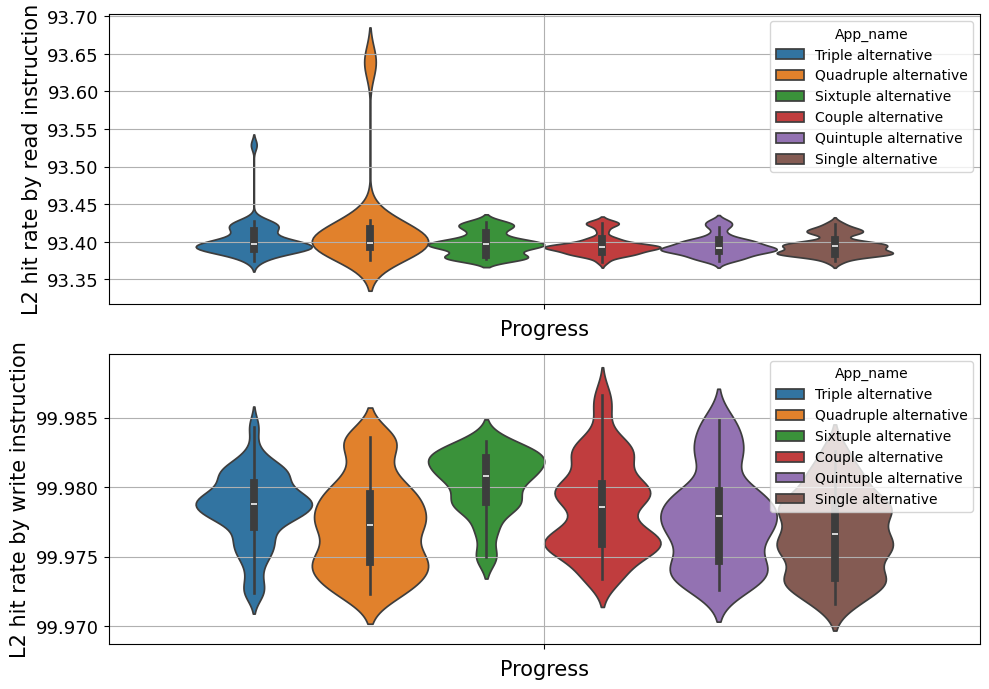

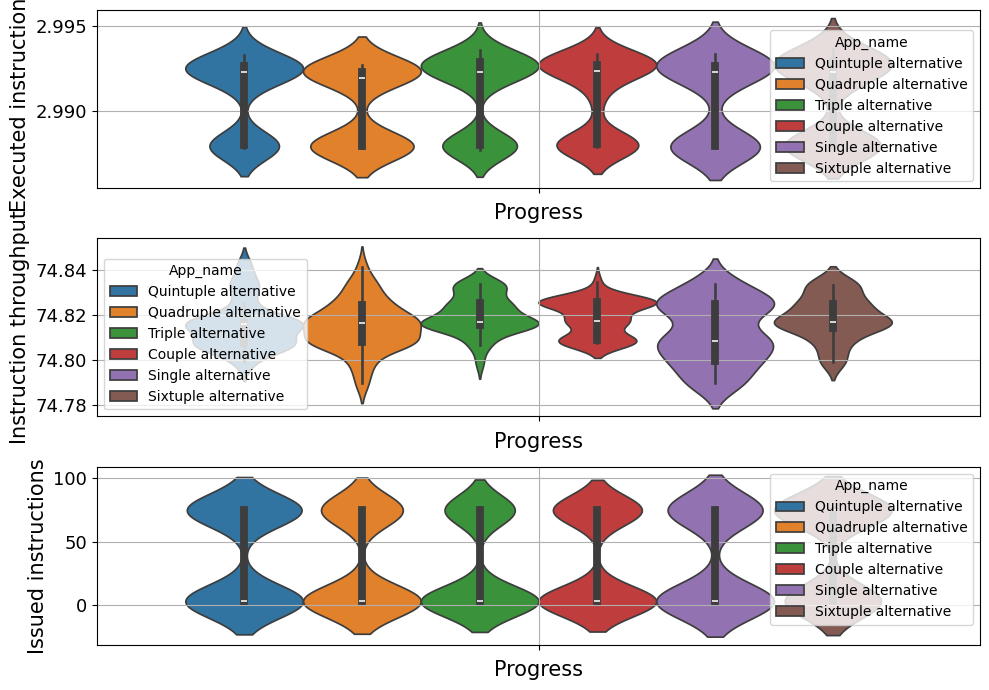

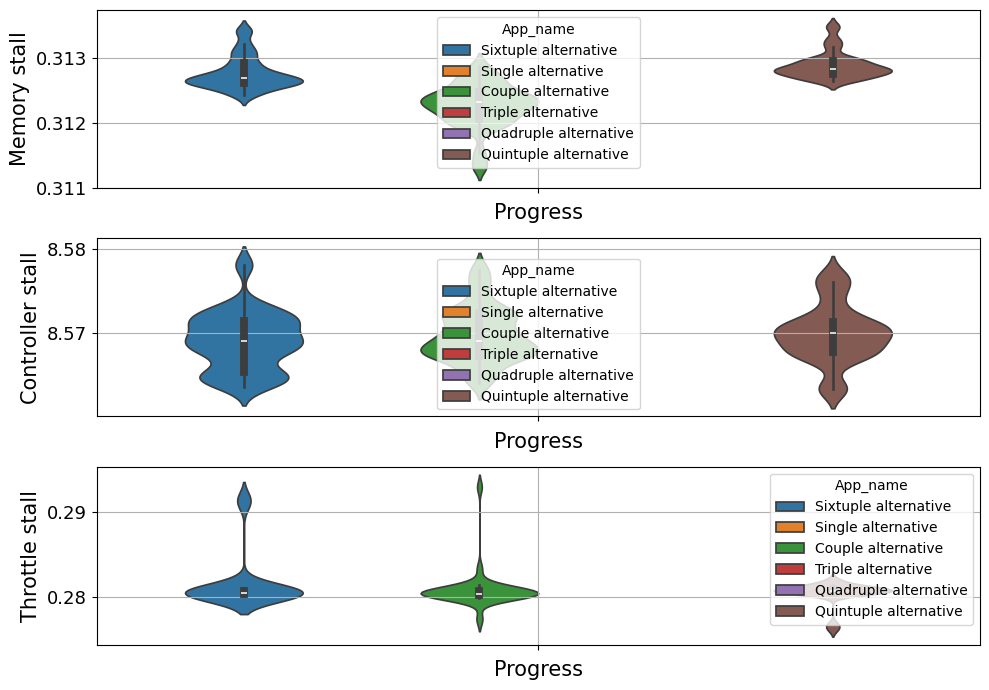

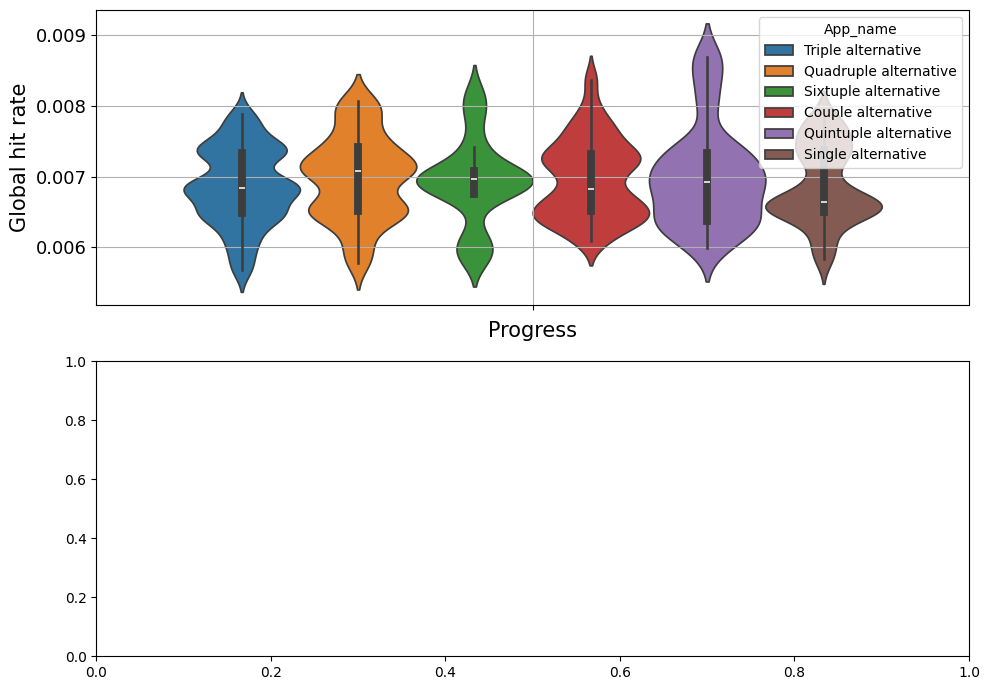

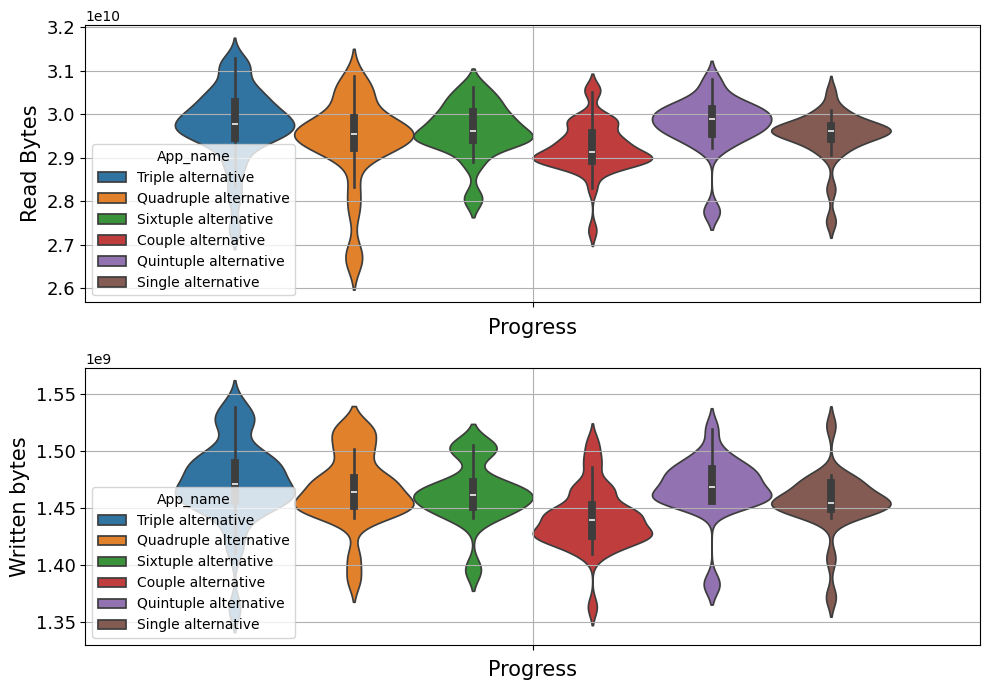

In [14]:
for df_idx in range(len(list(merged_dfs.values()))):
    HR_location = list(merged_dfs.keys())[df_idx]
    # data_to_corr = merged_dfs[HR_location].select_dtypes(include=['float64', 'int64'])
    # data_to_corr = merged_dfs[HR_location][merged_dfs[HR_location]['App_name']=='MobileNetV2'].select_dtypes(include=['float64', 'int64'])
    merged_df = merged_dfs[HR_location]
    if HR_location == 'Streaming Multiprocessor SubPartition':
        merged_df = merged_df[[
       'progress', "App_name",
       'Memory Stall', 'Controller Stall', 'Throttle Stall']]
        fig, ax = plt.subplots(3,1,figsize=(10,7))

        sns.violinplot(data=merged_df, y='Memory Stall', hue='App_name', ax = ax[0])
        ax[0].grid()
        ax[0].set_xlabel('Progress', fontsize=15)
        ax[0].set_ylabel('Memory stall', fontsize=15)
        ax[0].tick_params(axis='x', labelsize=13)
        ax[0].tick_params(axis='y', labelsize=13)

        sns.violinplot(data=merged_df, y='Controller Stall', hue='App_name', ax = ax[1])
        ax[1].grid()
        ax[1].set_xlabel('Progress', fontsize=15)
        ax[1].set_ylabel('Controller stall', fontsize=15)
        ax[1].tick_params(axis='x', labelsize=13)
        ax[1].tick_params(axis='y', labelsize=13)

        sns.violinplot(data=merged_df, y='Throttle Stall', hue='App_name', ax = ax[2])
        ax[2].grid()
        ax[2].set_xlabel('Progress', fontsize=15)
        ax[2].set_ylabel('Throttle stall', fontsize=15)
        ax[2].tick_params(axis='x', labelsize=13)
        ax[2].tick_params(axis='y', labelsize=13)
        plt.tight_layout()

    elif HR_location == 'Streaming Multiprocessor':
        merged_df = merged_df[[
       'progress','Executed instructions', "App_name",
       'Instruction throughput', 'Issued instructions']]
        fig, ax = plt.subplots(3,1,figsize=(10,7))

        print(merged_df[merged_df['App_name']=='GPU-burn']['Instruction throughput'].describe())
        sns.violinplot(data=merged_df, y='Executed instructions', hue='App_name', ax = ax[0])
        ax[0].grid()
        ax[0].set_xlabel('Progress', fontsize=15)
        ax[0].set_ylabel('Executed instructions', fontsize=15)
        ax[0].tick_params(axis='x', labelsize=13)
        ax[0].tick_params(axis='y', labelsize=13)

        sns.violinplot(data=merged_df, y='Instruction throughput', hue='App_name', ax = ax[1])
        ax[1].grid()
        ax[1].set_xlabel('Progress', fontsize=15)
        ax[1].set_ylabel('Instruction throughput', fontsize=15)
        ax[1].tick_params(axis='x', labelsize=13)
        ax[1].tick_params(axis='y', labelsize=13)

        sns.violinplot(data=merged_df, y='Issued instructions', hue='App_name', ax = ax[2])
        ax[2].grid()
        ax[2].set_xlabel('Progress', fontsize=15)
        ax[2].set_ylabel('Issued instructions', fontsize=15)
        ax[2].tick_params(axis='x', labelsize=13)
        ax[2].tick_params(axis='y', labelsize=13)
        plt.tight_layout()

    elif HR_location == 'L2 Cache':
        merged_df = merged_df[[ "App_name",
       'progress','L2 hit rate by read instruction',
       'L2 hit rate by write instruction']]
        
        fig, ax = plt.subplots(2,1,figsize=(10,7))
        sns.violinplot(data=merged_df, y='L2 hit rate by read instruction', hue='App_name', ax = ax[0])
        ax[0].grid()
        ax[0].set_xlabel('Progress', fontsize=15)
        ax[0].set_ylabel('L2 hit rate by read instruction', fontsize=15)
        ax[0].tick_params(axis='x', labelsize=13)
        ax[0].tick_params(axis='y', labelsize=13)

        sns.violinplot(data=merged_df, y='L2 hit rate by write instruction', hue='App_name', ax = ax[1])
        ax[1].grid()
        ax[1].set_xlabel('Progress', fontsize=15)
        ax[1].set_ylabel('L2 hit rate by write instruction', fontsize=15)
        ax[1].tick_params(axis='x', labelsize=13)
        ax[1].tick_params(axis='y', labelsize=13)
        plt.tight_layout()

    elif HR_location == 'L1 Cache':
        merged_df = merged_df[[ "App_name",
       'progress','Global hit rate']]
        
        fig, ax = plt.subplots(2,1,figsize=(10,7))
        sns.violinplot(data=merged_df, y='Global hit rate', hue='App_name', ax = ax[0])
        ax[0].grid()
        ax[0].set_xlabel('Progress', fontsize=15)
        ax[0].set_ylabel('Global hit rate', fontsize=15)
        ax[0].tick_params(axis='x', labelsize=13)
        ax[0].tick_params(axis='y', labelsize=13)
        plt.tight_layout()

    elif HR_location == 'Dynamic RAM':
        merged_df = merged_df[[ "App_name",
       'progress','Read Bytes', 'Written bytes']]
        
        fig, ax = plt.subplots(2,1,figsize=(10,7))
        sns.violinplot(data=merged_df, y='Read Bytes', hue='App_name', ax = ax[0])
        ax[0].grid()
        ax[0].set_xlabel('Progress', fontsize=15)
        ax[0].set_ylabel('Read Bytes', fontsize=15)
        ax[0].tick_params(axis='x', labelsize=13)
        ax[0].tick_params(axis='y', labelsize=13)

        sns.violinplot(data=merged_df, y='Written bytes', hue='App_name', ax = ax[1])
        ax[1].grid()
        ax[1].set_xlabel('Progress', fontsize=15)
        ax[1].set_ylabel('Written bytes', fontsize=15)
        ax[1].tick_params(axis='x', labelsize=13)
        ax[1].tick_params(axis='y', labelsize=13)
        plt.tight_layout()

        
    # data = list(merged_dfs.values())[df_idx]
    
    # ax[df_idx][0].set_title(f"Grouped per: {HR_location}", fontsize=20, pad=40)
    # ax[df_idx][0].grid()
    # ax[df_idx][0].set_xlabel('Performance counter', fontsize=15)
    # ax[df_idx][0].set_ylabel('Performance counter', fontsize=15)
    # ax[df_idx][1].tick_params(axis='x', labelrotation=90, labelsize=13)
    # ax[df_idx][0].tick_params(axis='x', labelrotation=90, labelsize=13)
    # ax[df_idx][0].set_xticklabels([])
    # ax[df_idx][1].set_xticklabels([])
    # ax[df_idx][0].set_xlabel('')

## PC-Telemetry correlation

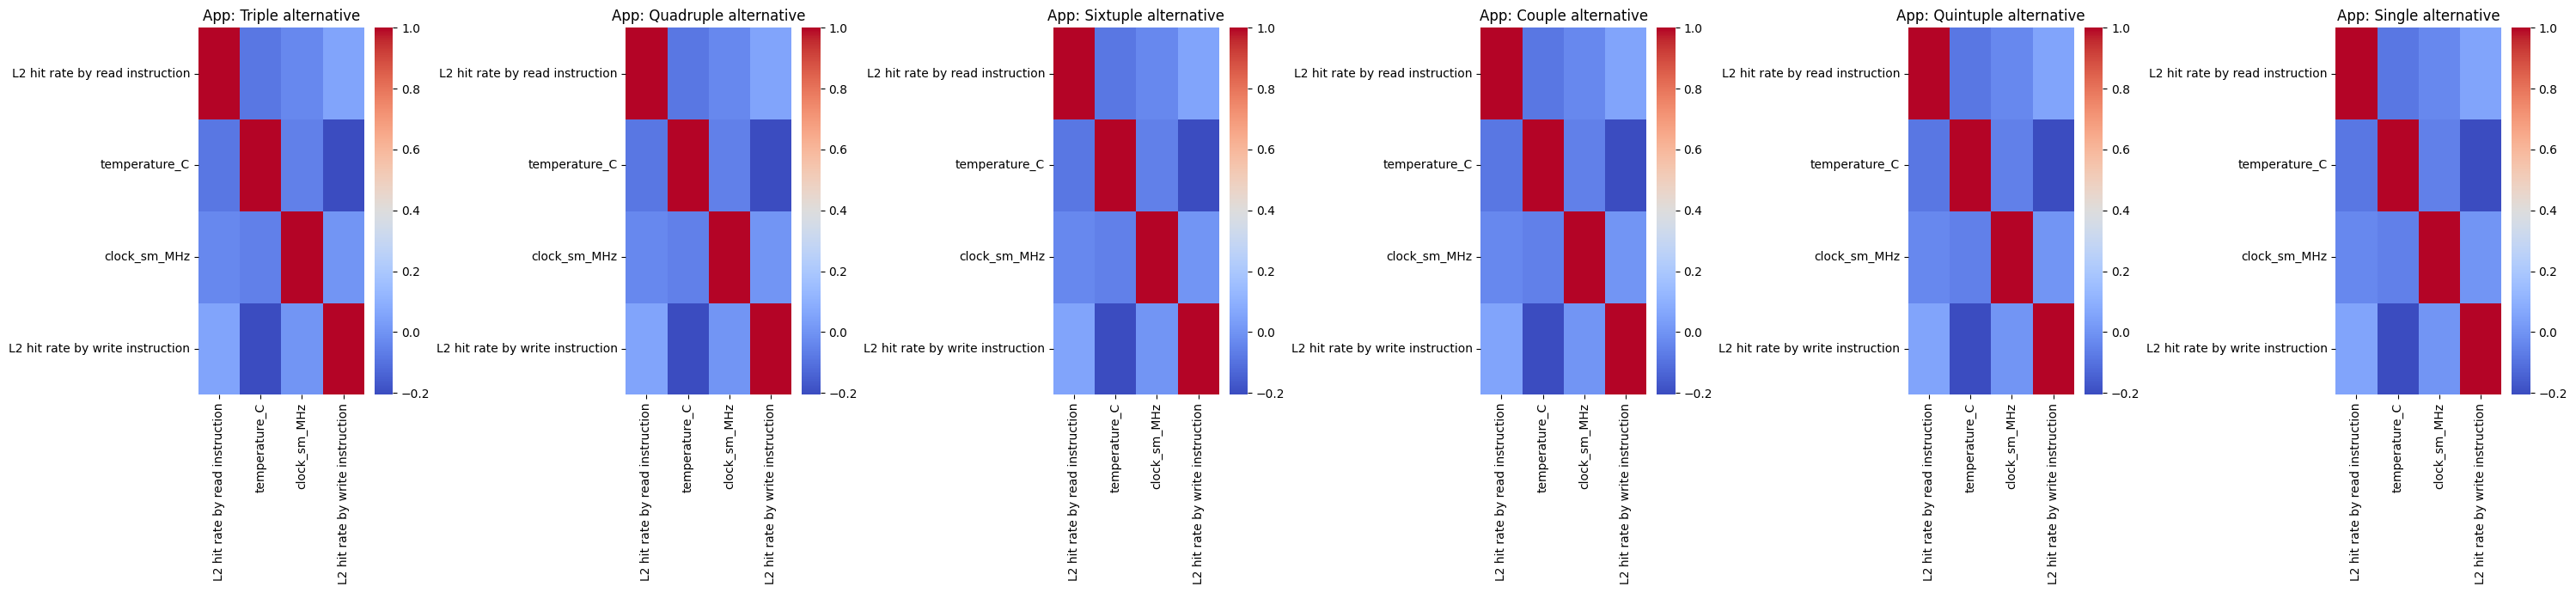

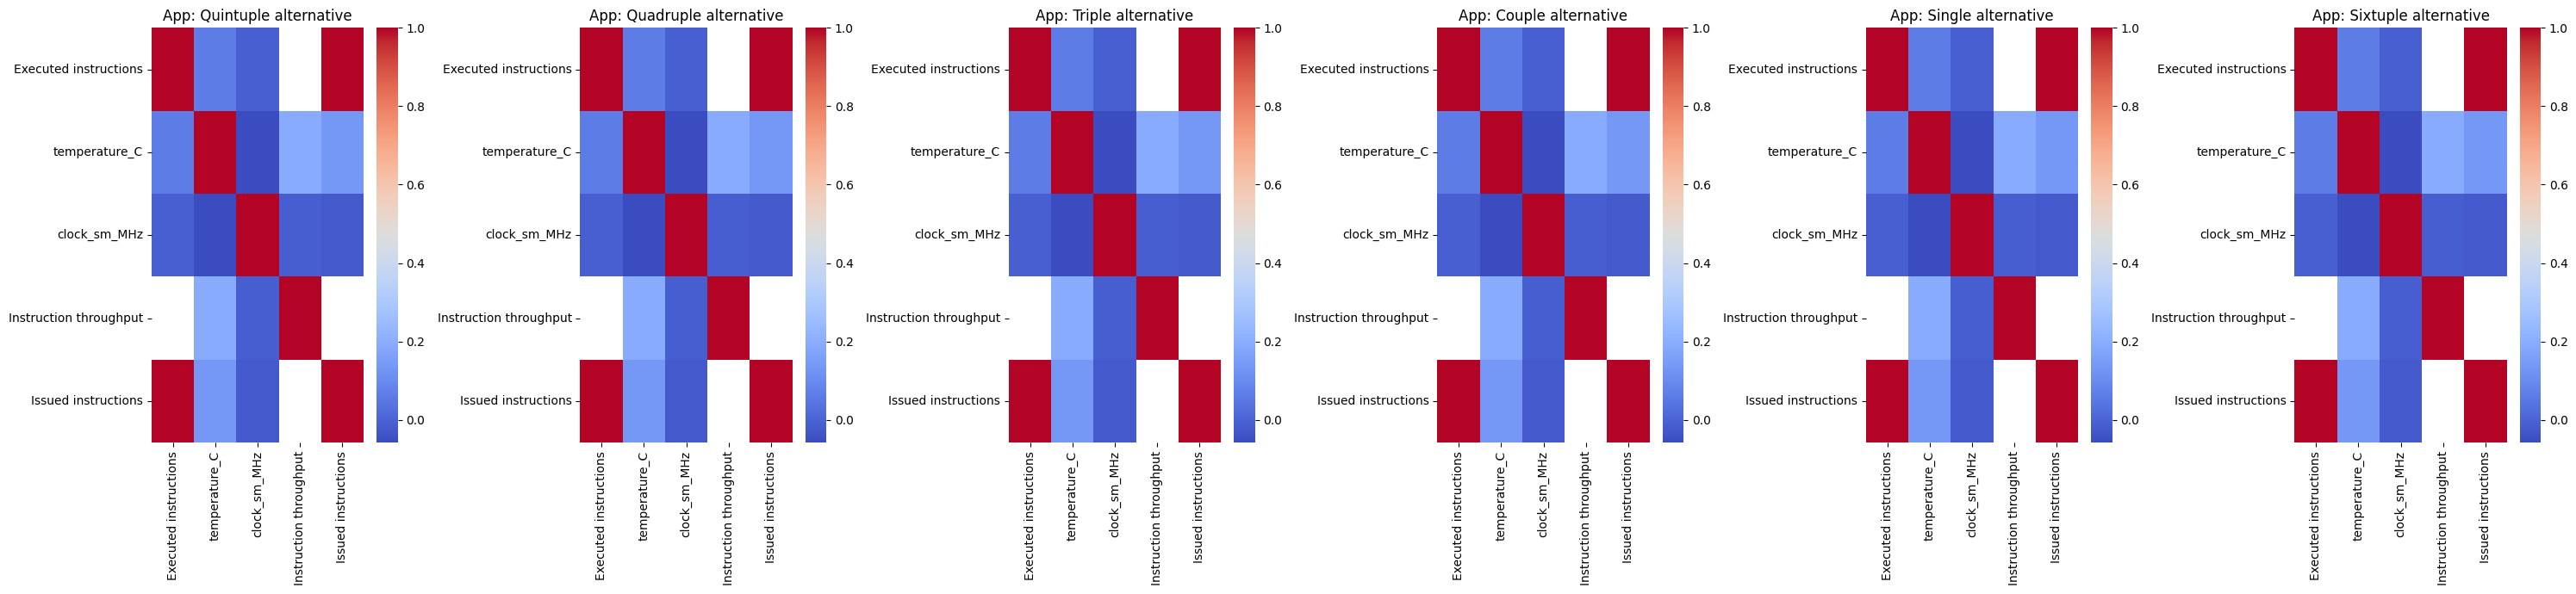

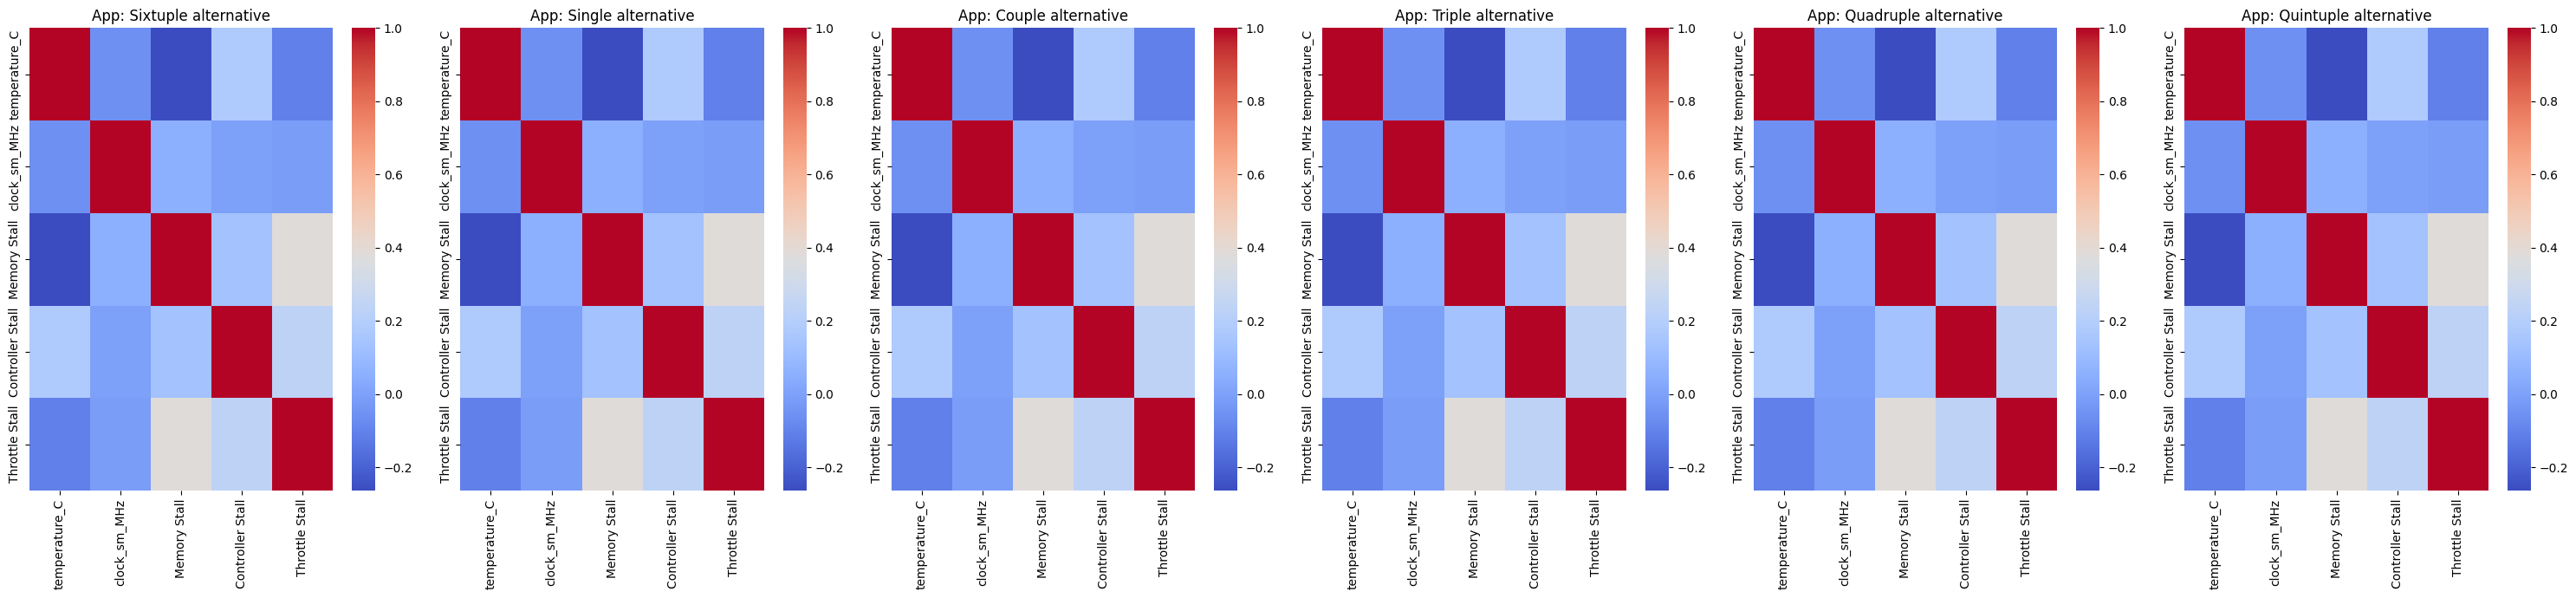

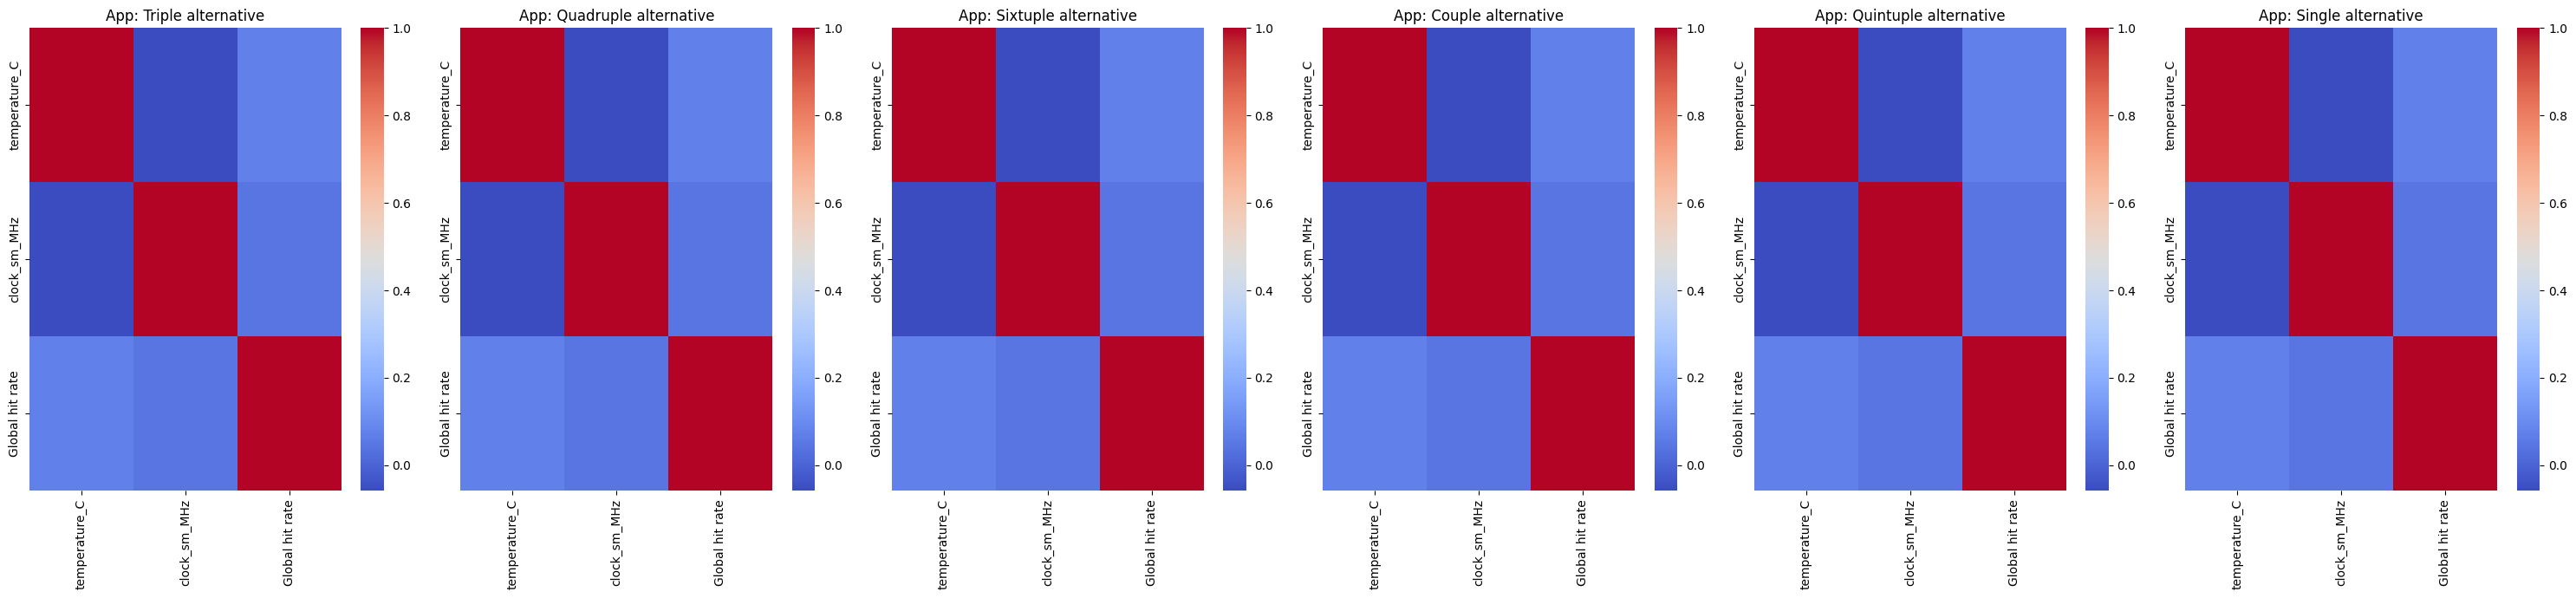

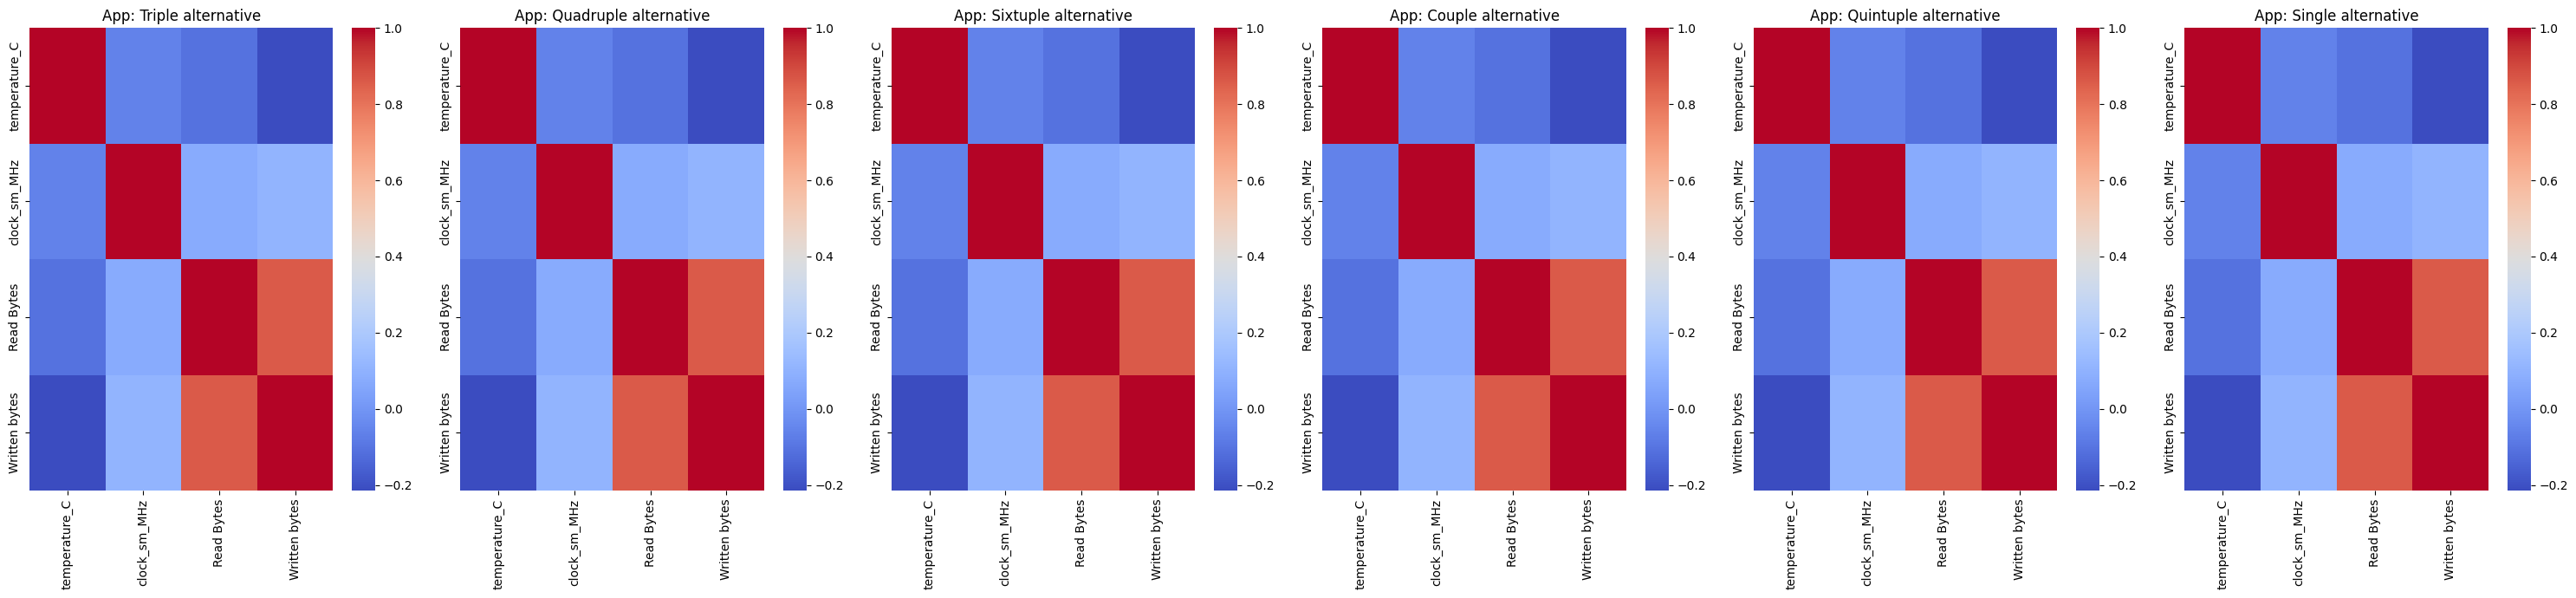

In [18]:
for df_idx in range(len(list(merged_dfs.values()))):
    HR_location = list(merged_dfs.keys())[df_idx]
    # data_to_corr = merged_dfs[HR_location].select_dtypes(include=['float64', 'int64'])
    # data_to_corr = merged_dfs[HR_location][merged_dfs[HR_location]['App_name']=='MobileNetV2'].select_dtypes(include=['float64', 'int64'])
    merged_df = merged_dfs[HR_location]
    if HR_location == 'Streaming Multiprocessor SubPartition':
        merged_df = merged_df[[
        "App_name", 'temperature_C', 'clock_sm_MHz',
       'Memory Stall', 'Controller Stall', 'Throttle Stall']]

    elif HR_location == 'Streaming Multiprocessor':
        merged_df = merged_df[[
       'Executed instructions', "App_name", 'temperature_C', 'clock_sm_MHz',
       'Instruction throughput', 'Issued instructions']]
        
    elif HR_location == 'L2 Cache':
        merged_df = merged_df[[ "App_name",
       'L2 hit rate by read instruction', 'temperature_C', 'clock_sm_MHz',
       'L2 hit rate by write instruction']]
        
    elif HR_location == 'L1 Cache':
        merged_df = merged_df[[ "App_name", 'temperature_C', 'clock_sm_MHz',
       'Global hit rate']]

    elif HR_location == 'Dynamic RAM':
        merged_df = merged_df[[ "App_name", 'temperature_C', 'clock_sm_MHz',
       'Read Bytes', 'Written bytes']]

    fig, ax = plt.subplots(1,6,figsize=(30,7))
    for app_idx in range(len(merged_df['App_name'].unique())):
        
        matrix = merged_df.loc[:, merged_df.columns != 'App_name'].corr(method='spearman')
        sns.heatmap(matrix, annot=False, cmap='coolwarm', ax=ax[app_idx])
        ax[app_idx].set_title(f"App: {merged_df['App_name'].unique()[app_idx]}")
    plt.tight_layout()